# ES335: Assignment 3, Task 3

### Problem Statement
Train on MNIST dataset using an MLP. The original training dataset contains 60,000 images and test contains 10,000 images. If you are short on compute, use a stratified subset of a smaller number of images. But, the test set remains the same 10,000 images. Compare against RF and Logistic Regression models.  The metrics can be: F1-score, confusion matrix. What do you observe? What all digits are commonly confused? 

Let us assume your MLP has 30 neurons in first layer, 20 in second layer and then 10 finally for the output layer (corresponding to 10 classes). On the trained MLP, plot the t-SNE for the output from the layer containing 20 neurons for the 10 digits. Contrast this with the t-SNE for the same layer but for an untrained model. What do you conclude? 

Now, use the trained MLP to predict on the Fashion-MNIST dataset. What do you observe? How do the embeddings (t-SNE viz for the second layer compare for MNIST and Fashion-MNIST images) [3 marks]


## Basic imports

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from keras.datasets import mnist, fashion_mnist
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

torch.manual_seed(42)
np.random.seed(42)

## Loading the dataset

In [38]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X.reshape(-1, 28 * 28)
test_X = test_X.reshape(-1, 28 * 28)

train_X = torch.from_numpy(train_X).float().reshape(-1, 28 * 28) / 255
train_y = torch.from_numpy(train_y).long()

test_X = torch.from_numpy(test_X).float().reshape(-1, 28 * 28) / 255
test_y = torch.from_numpy(test_y).long()

## Utility functions

In [25]:
def print_metrics(model):
	pred = model.predict(test_X)
	acc = (pred == test_y).float().mean()
	print(f"Accuracy: {acc.item()}")
  
	cm = confusion_matrix(test_y, pred)

	f1 = f1_score(test_y, pred, average=None)
	accuracies = []
	recalls = []
 
	for i in range(10):
		accuracies.append(cm[i, i] / (cm[:, i].sum() + 1e-7))
		recalls.append(cm[i, i] / (cm[i].sum() + 1e-7))
	df = pd.DataFrame(np.array([f1, accuracies, recalls]).T, index=range(10), columns=["F1 Score", "Accuracy", "Recall"])
	df.index.name = "Class"
	display(df.T)
 
	plt.figure(figsize=(6, 6))
	sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
	plt.title("Confusion Matrix")
	plt.xlabel("Predicted")
	plt.ylabel("Actual")
	plt.show()
 
	return cm
 
def plot_losses(losses):
	plt.plot(losses)
	plt.title("Losses")
	plt.xlabel("Epoch")
	plt.ylabel("Loss") 
 
def train(model, lr=0.01, epochs=100, verbose=False, optimizer='adam', reg=0, **kwargs):
	loss = nn.CrossEntropyLoss()
	optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg) if optimizer == 'adam' else torch.optim.SGD(model.parameters(), lr=lr)
	
	losses = []
	for i in range(epochs):
		optim.zero_grad()
		pred = model(train_X, kwargs)
		l = loss(pred, train_y)
		l.backward()
		optim.step()
		losses.append(l.item())
  
		if verbose and i % (epochs//10) == 0:
			print(f"Epoch {i} Loss: {l.item()}")
  
	return losses

def plot_tsne(model):
	feats = model.get_feats(train_X)

	for i in range(len(feats)):
		tsne = TSNE(n_components=2, random_state=42)
		embeddings_2d = tsne.fit_transform(feats[i])
		plt.figure(figsize=(6, 6))
		scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=train_y, cmap="tab10")
		# print the legend of the classes
		legend_labels = [f"Class {label}" for label in range(10)]
		plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)
		plt.title(f"Layer {i + 1} T-SNE")
		plt.show()

## Training and comparing the performance of MLP, Random Forest and Logistic Regression for the Handwritten digits classification task

In this section, we train the model on the MNIST dataset and compare the performance of MLP, Random Forest and Logistic Regression models. We will use the F1-score and confusion matrix as the metrics to compare the models.

The dataset consists of 60,000 training images and 10,000 test images.

The results are as follows:

| Model | Accuracy |
|-------|----------|
| MLP   | 0.9732   |
| RF    | 0.9267   |
| LR    | 0.9698   |

We can see that the MLP model perfoms the best among the three models. However random forest also performs close to that of MLP, this is beacause the digits in the MNIST dataset are centered and scaled.

### Training the MLP model

In this section, we train a simple MLP for the MNIST handwritten digits dataset. The architecture of the MLP is as follows:
- Input layer: 784 neurons
- Hidden layer 1: 128 neurons
- Hidden layer 2: 128 neurons
- Hidden layer 3: 64 neurons
- Output layer: 10 neurons

We use the Adam optimizer and the cross-entropy loss function. The activation function used is sigmoid for the hidden layers and softmax for the output layer. However, we haven't explicitly passed the output through the softmax function since the loss function expects logits.

At the end we see the commonly miscalssified digits. We also plot a few of them and see that they are actually very similar looking to the misclassified digit.

In [35]:
class MLP(nn.Module):
    def __init__(self, act=nn.ReLU()):
        super().__init__()
        self.act = act
        self.l1 = nn.Linear(28 * 28, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64, 10)
        # we ignore the solfmax layer here, because we will be predicting the logits
        
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        x = self.act(x)
        x = self.l3(x)
        x = self.act(x)
        x = self.l4(x)
        return x
    
    def predict(self, x):
        return self.forward(x).argmax(dim=1)

In [ ]:
model = MLP(act=nn.Sigmoid())
losses = train(model, lr=0.001, epochs=5000, verbose=True, reg=1e-5)

Epoch 0 Loss: 2.32873272895813
Epoch 500 Loss: 0.097419373691082
Epoch 1000 Loss: 0.012913870625197887
Epoch 1500 Loss: 0.005220979452133179
Epoch 2000 Loss: 0.0035765517968684435
Epoch 2500 Loss: 0.002834911923855543
Epoch 3000 Loss: 0.002161999698728323
Epoch 3500 Loss: 0.001841495162807405
Epoch 4000 Loss: 0.0016334813553839922
Epoch 4500 Loss: 0.001490329741500318


In [36]:
model = torch.load('./models/mlp_large.pth', map_location='cpu')

C:\Users\DELL\AppData\Local\Temp\ipykernel_1040\590524421.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./models/mlp_large.pth', map_location='cpu'

#### The loss curve, and evaluating the model on the test set

Accuracy: 0.9732999801635742


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.984741,0.988576,0.974284,0.967838,0.977053,0.964286,0.977011,0.968370,0.965092,0.963111
Accuracy,0.981744,0.985977,0.975705,0.967359,0.978550,0.960000,0.978033,0.968841,0.965092,0.968907
Recall,0.987755,0.991189,0.972868,0.968317,0.975560,0.968610,0.975992,0.967899,0.965092,0.957384


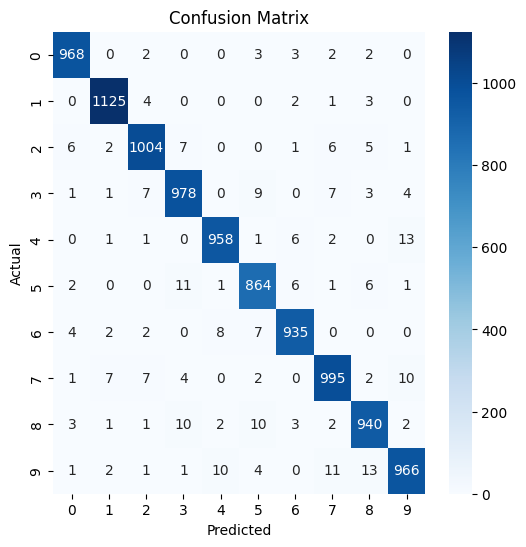

Most commonly confused with 0: [6 5]
Most commonly confused with 1: [2 8]
Most commonly confused with 2: [3 7]
Most commonly confused with 3: [5 7]
Most commonly confused with 4: [9 6]
Most commonly confused with 5: [3 8]
Most commonly confused with 6: [4 5]
Most commonly confused with 7: [9 2]
Most commonly confused with 8: [5 3]
Most commonly confused with 9: [8 7]


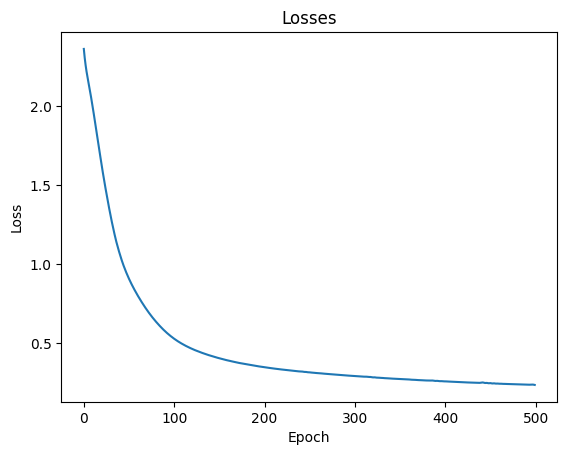

In [40]:
cm = print_metrics(model)
plot_losses(losses)

for i in range(10):
	print(f"Most commonly confused with {i}:", cm[i].argsort()[-3:-1][::-1])

# torch.save(model, 'models/mlp_large.pth')

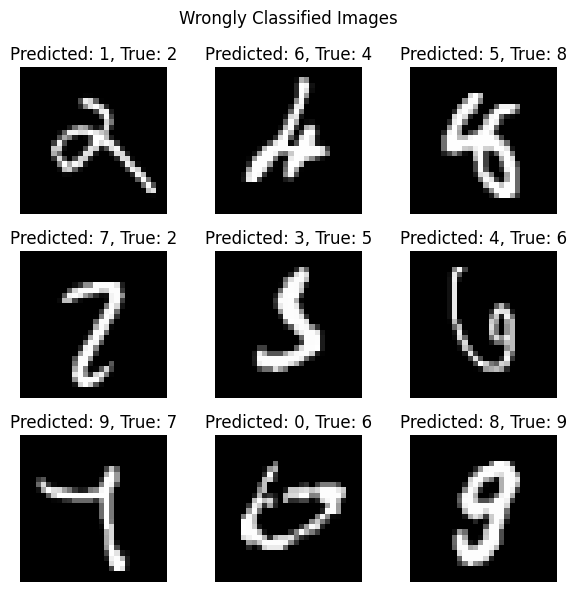

In [43]:
pred = model.predict(test_X)
wrong = test_X[pred != test_y]
wrong_pred = pred[pred != test_y]
wrong_true = test_y[pred != test_y]

fig, ax = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
	for j in range(3):
		ax[i, j].imshow(wrong[i * 3 + j].reshape(28, 28), cmap='gray')
		ax[i, j].set_title(f"Predicted: {wrong_pred[i * 3 + j]}, True: {wrong_true[i * 3 + j]}")
		ax[i, j].axis('off')
fig.suptitle("Wrongly Classified Images")
fig.tight_layout()

### Training the Logistic Regression model

In this section, we train a Logistic Regression model for the MNIST handwritten digits dataset. Again the model is trained for 5000 epochs, with a learning rate of 3e-4 and the Loss used is the cross-entropy loss.

In [44]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear = nn.Linear(28 * 28, 10)
        # Note that the activation is automatically applied in the loss function.
        
    def forward(self, x):
        return self.linear(x)
    
    def predict(self, x):
        return self.forward(x).argmax(dim=1)

In [ ]:
model = LogisticRegression()
losses = train(model, lr=3e-4, epochs=5000, verbose=True)

Epoch 0 Loss: 2.338815689086914
Epoch 500 Loss: 0.5376607179641724
Epoch 1000 Loss: 0.39382871985435486
Epoch 1500 Loss: 0.33996298909187317
Epoch 2000 Loss: 0.3106463849544525
Epoch 2500 Loss: 0.2916393280029297
Epoch 3000 Loss: 0.2780061960220337
Epoch 3500 Loss: 0.2675793766975403
Epoch 4000 Loss: 0.2592509686946869
Epoch 4500 Loss: 0.2523917555809021


In [46]:
model = torch.load('./models/lr.pth', map_location='cpu')

C:\Users\DELL\AppData\Local\Temp\ipykernel_1040\1119120393.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./models/lr.pth', map_location='cpu')


#### The loss curve, and evaluating the model on the test set

Accuracy: 0.926800012588501


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.966700,0.973730,0.915020,0.909990,0.932995,0.891938,0.944703,0.924427,0.885845,0.912525
Accuracy,0.956088,0.967798,0.933468,0.909091,0.930162,0.910152,0.935517,0.926686,0.875627,0.915254
Recall,0.977551,0.979736,0.897287,0.910891,0.935845,0.874439,0.954071,0.922179,0.896304,0.909812


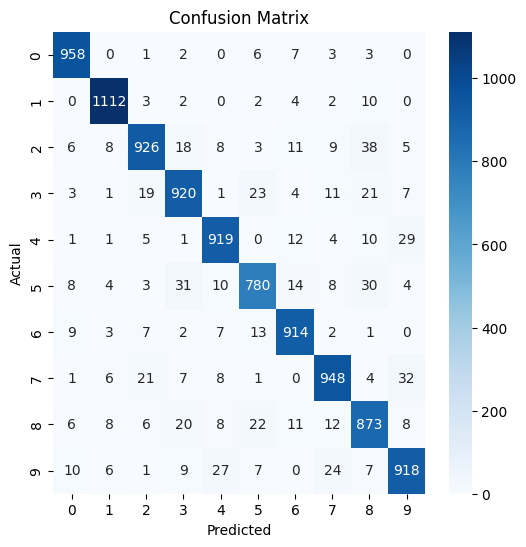

Most commonly confused with 0: [6 5]
Most commonly confused with 1: [8 6]
Most commonly confused with 2: [8 3]
Most commonly confused with 3: [5 8]
Most commonly confused with 4: [9 6]
Most commonly confused with 5: [3 8]
Most commonly confused with 6: [5 0]
Most commonly confused with 7: [9 2]
Most commonly confused with 8: [5 3]
Most commonly confused with 9: [4 7]


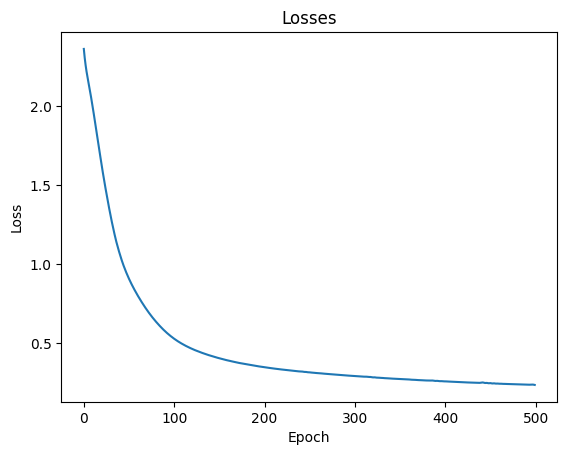

In [48]:
cm = print_metrics(model)
plot_losses(losses)
# torch.save(model, './models/lr.pth')

for i in range(10):
	print(f"Most commonly confused with {i}:", cm[i].argsort()[-3:-1][::-1])

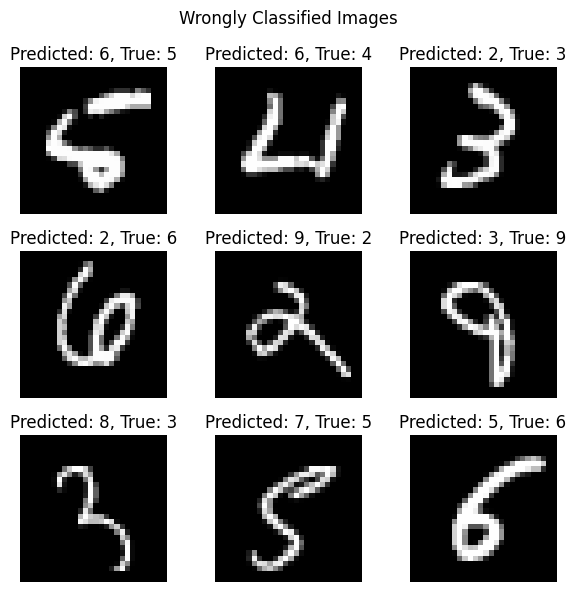

In [49]:
pred = model.predict(test_X)
wrong = test_X[pred != test_y]
wrong_pred = pred[pred != test_y]
wrong_true = test_y[pred != test_y]

fig, ax = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
	for j in range(3):
		ax[i, j].imshow(wrong[i * 3 + j].reshape(28, 28), cmap='gray')
		ax[i, j].set_title(f"Predicted: {wrong_pred[i * 3 + j]}, True: {wrong_true[i * 3 + j]}")
		ax[i, j].axis('off')
fig.suptitle("Wrongly Classified Images")
fig.tight_layout()

### Training a Random Forest

In this section, we train a Random Forest model for the MNIST handwritten digits dataset. We use 100 trees in the Random Forest model, with a maximum depth of 10. The impurity function used is the Gini impurity. After training the model, we evaluate it on the test set and get the following results.

Accuracy: 0.9485999941825867


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.975806,0.980736,0.940661,0.940417,0.943106,0.944191,0.965231,0.939379,0.936696,0.916342
Accuracy,0.964143,0.974761,0.944336,0.943227,0.949432,0.959491,0.959752,0.952048,0.939112,0.899713
Recall,0.987755,0.986784,0.937016,0.937624,0.936864,0.929372,0.970772,0.927043,0.934292,0.933598


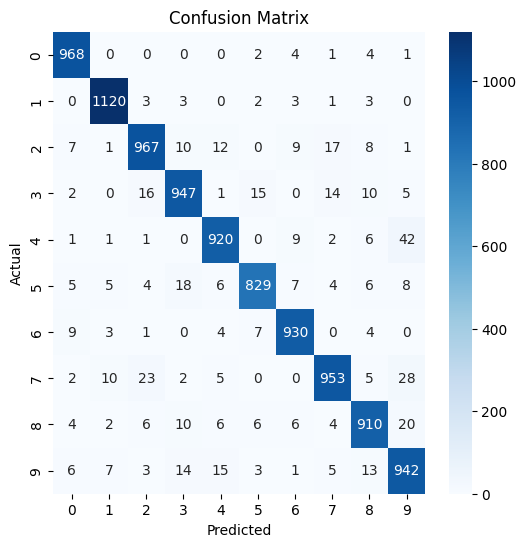

Most commonly confused with 0: [8 6]
Most commonly confused with 1: [8 6]
Most commonly confused with 2: [7 4]
Most commonly confused with 3: [2 5]
Most commonly confused with 4: [9 6]
Most commonly confused with 5: [3 9]
Most commonly confused with 6: [0 5]
Most commonly confused with 7: [9 2]
Most commonly confused with 8: [9 3]
Most commonly confused with 9: [4 3]


In [50]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, criterion='gini')
rf.fit(train_X, train_y)

cm = print_metrics(rf)

for i in range(10):
	print(f"Most commonly confused with {i}:", cm[i].argsort()[-3:-1][::-1])

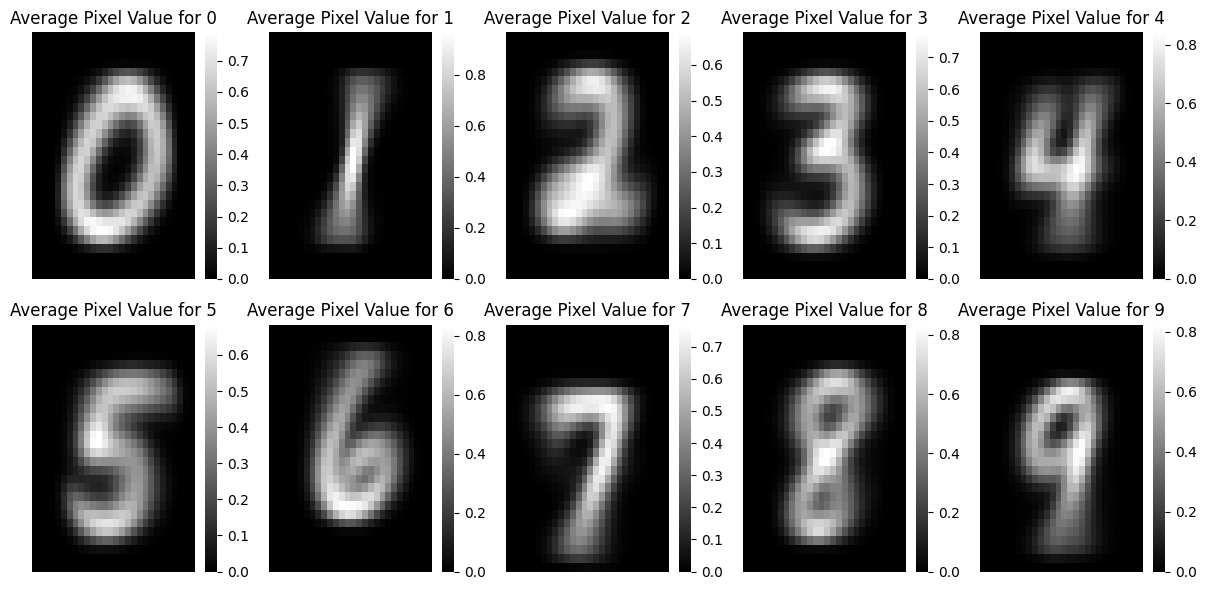

In [59]:
# plot the average pixel value for each class
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    sns.heatmap(train_X[train_y == i].reshape(-1, 28, 28).mean(0), cmap="gray")
    plt.title("Average Pixel Value for " + str(i))
    plt.axis('off')
plt.tight_layout()

## Visualizing the t-SNE embeddings for various layers of the MLP model

In this section, we visualize the t-SNE embeddings for the output of the hidden layers of the MLP model. The archetecture of the MLP model is as follows:

- Input layer: 784 neurons
- Hidden layer 1: 30 neurons
- Hidden layer 2: 20 neurons
- Output layer: 10 neurons

We first visualize the t-SNE embeddings of the untrained model and then the trained model. We can clearly see that in the trained model, the embeddings are more clustered and separated compared to the untrained model.

From the t-SNE embeddings, we can conclude that the MLP does to good job in learning the features for the MNIST dataset. Initially for the untrained model, it outputs random features, but after training, the embeddings are more clustered and separated.

In [7]:
class MLP(nn.Module):
	def __init__(self, act=nn.ReLU()):
		super().__init__()
		self.l1 = nn.Linear(28 * 28, 30)
		self.l2 = nn.Linear(30, 20)
		self.l3 = nn.Linear(20, 10)
		self.act = act
  
	def forward(self, x):
		x = self.l1(x)
		x = self.act(x)
		x = self.l2(x)
		x = self.act(x)
		x = self.l3(x)
		return x

	def predict(self, x):
		return self.forward(x).argmax(dim=1)

	def get_feats(self, x):
		feats = []
		x = self.l1(x)
		x = self.act(x)
		feats.append(x.detach().numpy())
		x = self.l2(x)
		x = self.act(x)
		feats.append(x.detach().numpy())
		x = self.l3(x)
		feats.append(x.detach().numpy())

		return feats

	def featurize(self, x):
		x = self.l1(x)
		x = self.act(x)
		x = self.l2(x)
		x = self.act(x)
		return x

### t-SNE embeddings for the untrained model

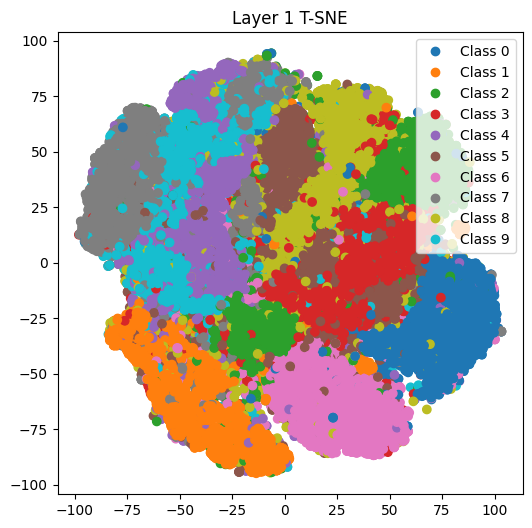

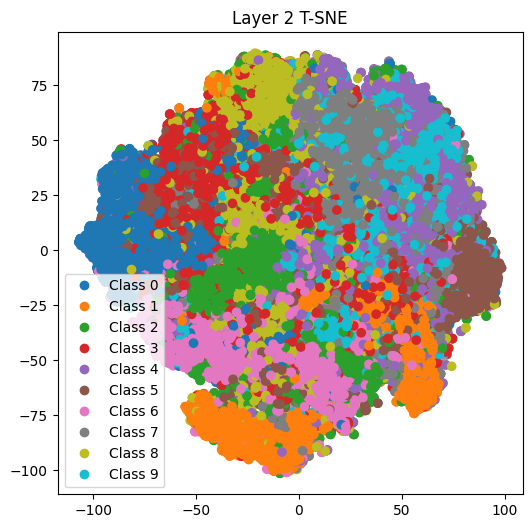

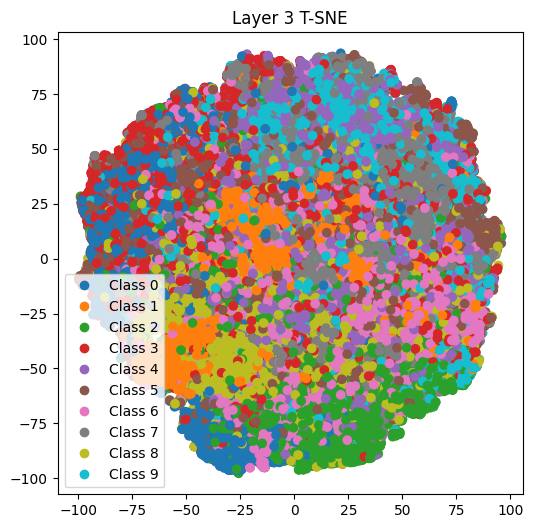

In [33]:
model = MLP(act=nn.Sigmoid())
plot_tsne(model)

### t-SNE embeddings for the trained model

In [ ]:
model = MLP(act=nn.Sigmoid())
losses = train(model, lr=1e-3, epochs=2000, verbose=True)

Epoch 0 Loss: 2.3494770526885986
Epoch 200 Loss: 1.370924472808838
Epoch 400 Loss: 0.7223779559135437
Epoch 600 Loss: 0.4481320083141327
Epoch 800 Loss: 0.31671544909477234
Epoch 1000 Loss: 0.2428949922323227
Epoch 1200 Loss: 0.1954164057970047
Epoch 1400 Loss: 0.16228774189949036
Epoch 1600 Loss: 0.13738064467906952
Epoch 1800 Loss: 0.11800014972686768


In [75]:
model_ = torch.load('./models/MLP.pth', map_location='cpu')

model = MLP(act=nn.Sigmoid())
model.load_state_dict(model_.state_dict())
del model_

C:\Users\DELL\AppData\Local\Temp\ipykernel_7576\4092612139.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ = torch.load('./models/MLP.pth', map_location='cpu')


Accuracy: 0.9529999494552612


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.978788,0.983289,0.943853,0.937469,0.950870,0.927190,0.960540,0.95428,0.942387,0.944804
Accuracy,0.969000,0.981563,0.942940,0.932419,0.955761,0.941109,0.955579,0.95428,0.944330,0.948104
Recall,0.988776,0.985022,0.944767,0.942574,0.946029,0.913677,0.965553,0.95428,0.940452,0.941526


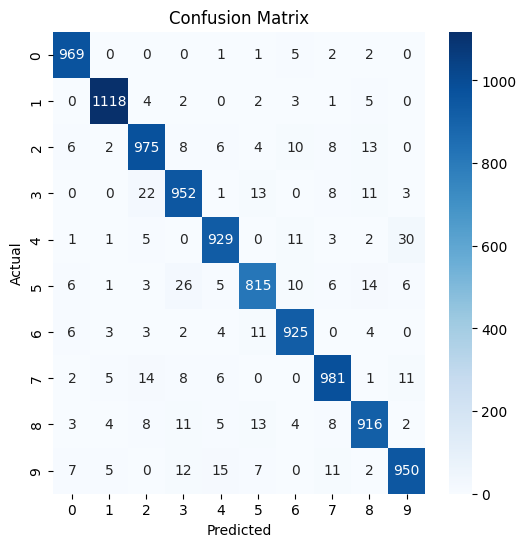

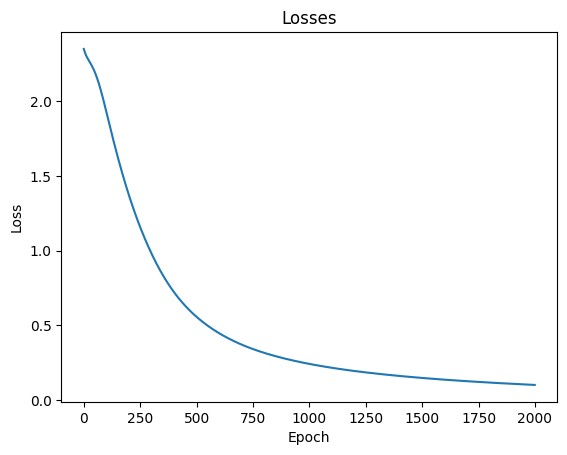

In [ ]:
print_metrics(model)
plot_losses(losses)

torch.save(model, './models/MLP.pth')

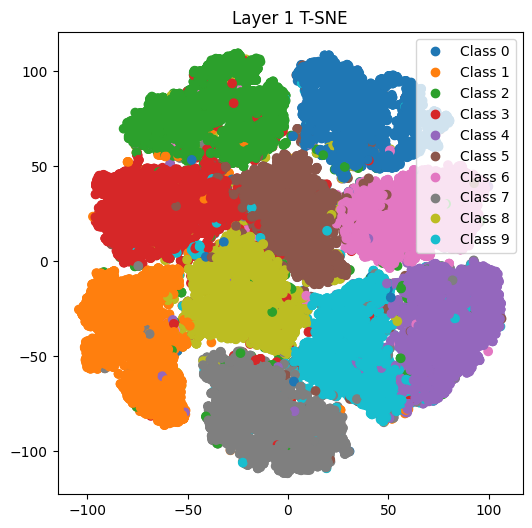

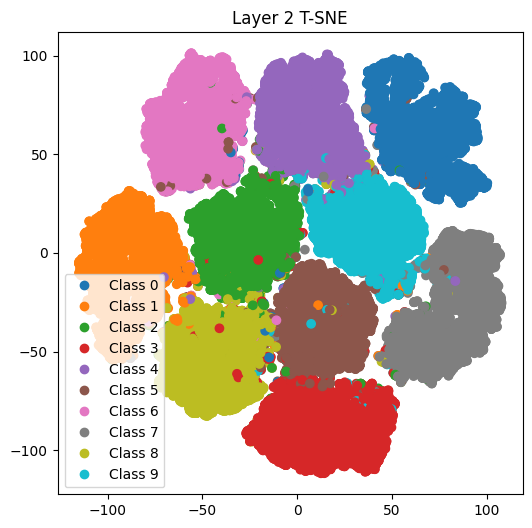

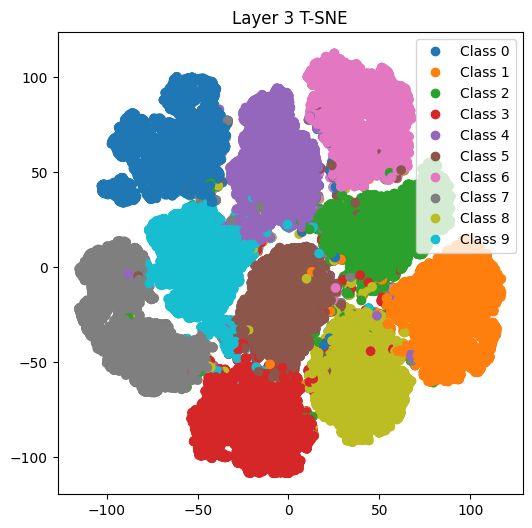

In [22]:
plot_tsne(model)

### Visualizing the t-SNE embeddings for the input data

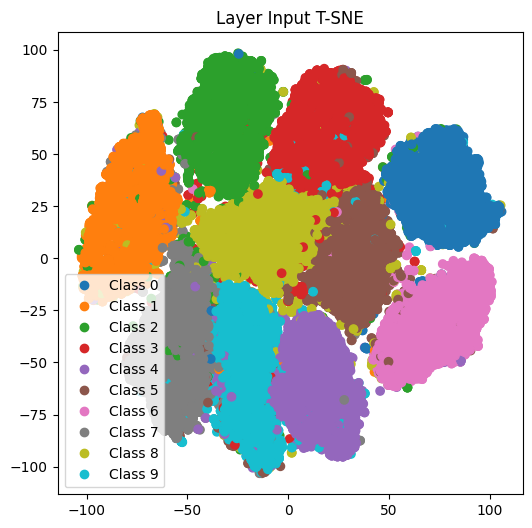

In [34]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(train_X)
plt.figure(figsize=(6, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=train_y, cmap="tab10")
# print the legend of the classes
legend_labels = [f"Class {label}" for label in range(10)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)
plt.title(f"Layer Input T-SNE")
plt.show()

## Using the trained MLP model to predict on the Fashion-MNIST dataset

In this section, we used the trained MLP model to predict on the Fashion-MNIST dataset. The Fashion-MNIST dataset consists of 60,000 training images and 10,000 test images. We evaluate the model on the test set and get very bad results. This is expected since the model was trained on the MNIST dataset which consists of handwritten digits and not on the Fashion-MNIST dataset which consists of images of clothing items.

After that we visualize the t-SNE embeddings for the second layer of the MLP model for the Fashion-MNIST dataset.

Now we do transfer learning to train the MLP model on the Fashion-MNIST dataset. In this, we take the pretrained model on the MNIST dataset, remove the last layer and add a new layer with 10 neurons corresponding to the 10 classes in the Fashion-MNIST dataset. We then train the model on the Fashion-MNIST dataset and evaluate it on the test set. After training the model only for 500 epochs, we get a better accuracy than training the same archetecture on the Fashion-MNIST dataset from scratch for 1000 epochs.

In [22]:
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()
train_X = train_X.reshape(-1, 28 * 28)
test_X = test_X.reshape(-1, 28 * 28)

train_X = torch.from_numpy(train_X).float().reshape(-1, 28 * 28) / 255
train_y = torch.from_numpy(train_y).long()

test_X = torch.from_numpy(test_X).float().reshape(-1, 28 * 28) / 255
test_y = torch.from_numpy(test_y).long()

In [16]:
model_ = torch.load('./models/MLP.pth', map_location='cpu')

model = MLP(act=nn.Sigmoid())
model.load_state_dict(model_.state_dict())
del model_

C:\Users\DELL\AppData\Local\Temp\ipykernel_1040\4092612139.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ = torch.load('./models/MLP.pth', map_location='cpu')


Accuracy: 0.0364999994635582


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.037175,0.0,0.008714,0.118223,0.0,0.063705,0.007394,0.007540,0.001953,0.0
Accuracy,0.034722,0.0,0.005653,0.099794,0.0,0.040297,0.048780,0.065574,0.041667,0.0
Recall,0.040000,0.0,0.019000,0.145000,0.0,0.152000,0.004000,0.004000,0.001000,0.0


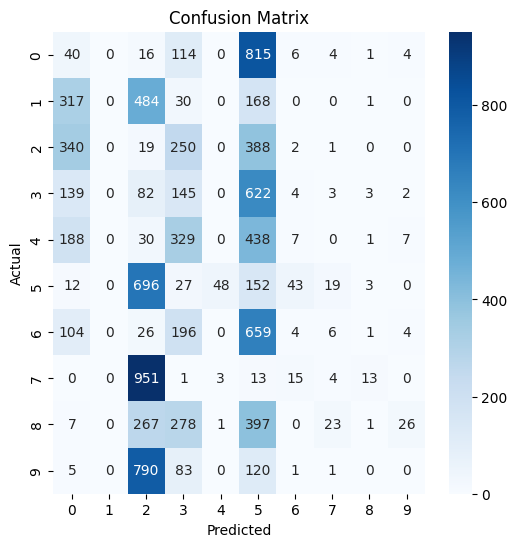

In [17]:
print_metrics(model)

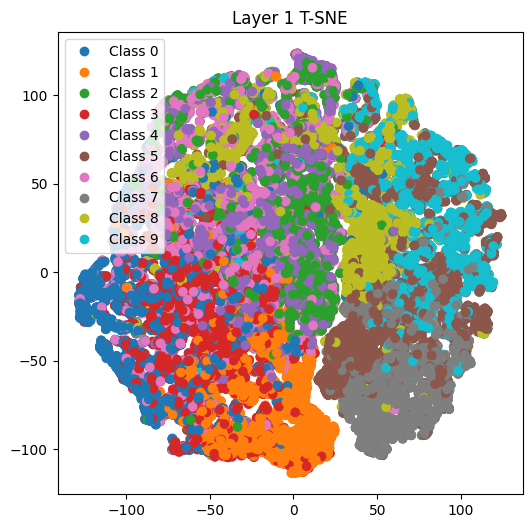

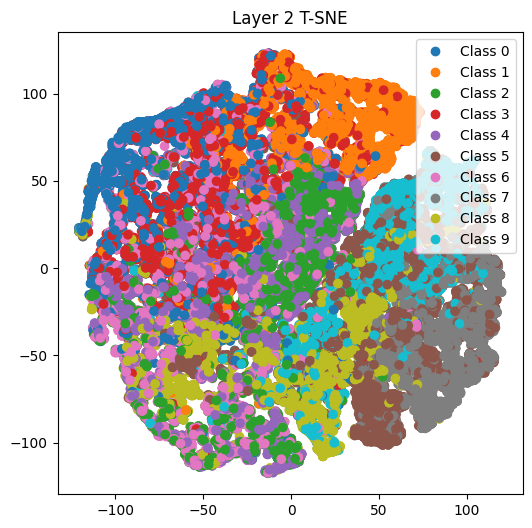

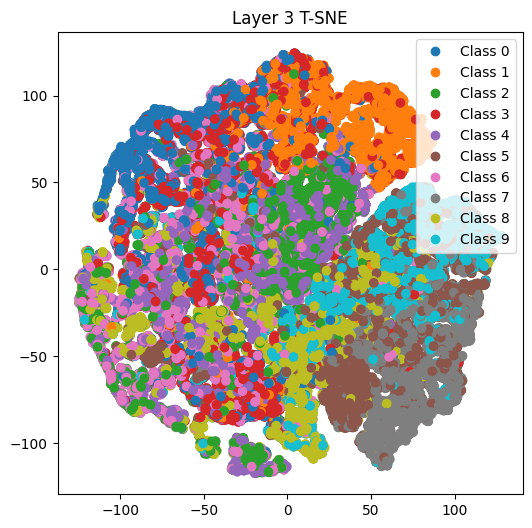

In [73]:
plot_tsne(model)

In [18]:
class MLP_head(nn.Module):
    def __init__(self, featurizer):
        super().__init__()
        self.featurizer = featurizer
        self.l1 = nn.Linear(20, 10)
        
    def forward(self, x, freeze=True):
        x = self.featurizer.featurize(x)
        if freeze:
            x = x.detach()
        x = self.l1(x)
        return x
    
    def predict(self, x):
        return self.forward(x).argmax(dim=1)
    
    def get_feats(self, x):
        feats = []
        x = self.featurizer.l1(x)
        x = self.featurizer.act(x)
        feats.append(x.detach().numpy())
        x = self.featurizer.l2(x)
        x = self.featurizer.act(x)
        feats.append(x.detach().numpy())
        x = self.l1(x)
        feats.append(x.detach().numpy())
        return feats

In [19]:
mlp_head = MLP_head(model)

In [20]:
losses = train(mlp_head, lr=1e-2, epochs=500, verbose=True)

Epoch 0 Loss: 2.3638057708740234
Epoch 50 Loss: 0.9059516787528992
Epoch 100 Loss: 0.5257925391197205
Epoch 150 Loss: 0.40199193358421326
Epoch 200 Loss: 0.3453500270843506
Epoch 250 Loss: 0.3126812279224396
Epoch 300 Loss: 0.288839727640152
Epoch 350 Loss: 0.27024057507514954
Epoch 400 Loss: 0.2555933892726898
Epoch 450 Loss: 0.24446028470993042


Accuracy: 0.8669000267982483


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.820020,0.967546,0.776843,0.864703,0.780971,0.948692,0.669638,0.944032,0.951996,0.949576
Accuracy,0.829243,0.981481,0.768854,0.863410,0.774067,0.954453,0.663395,0.935231,0.962206,0.948156
Recall,0.811000,0.954000,0.785000,0.866000,0.788000,0.943000,0.676000,0.953000,0.942000,0.951000


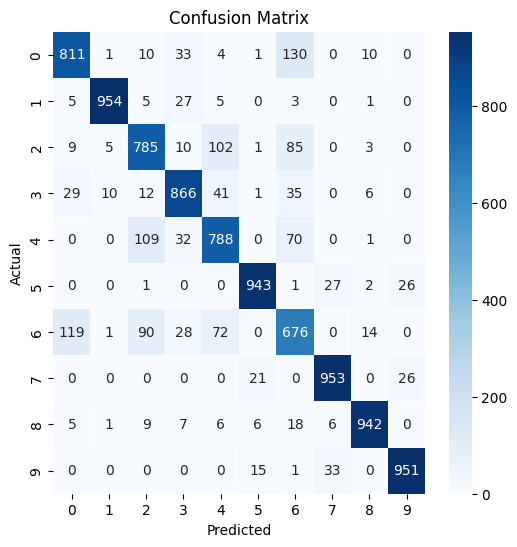

In [89]:
print_metrics(mlp_head)

In [64]:
model = MLP(act=nn.Sigmoid())
losses = train(model, lr=1e-3, epochs=1000, verbose=True)

Epoch 0 Loss: 2.3258116245269775
Epoch 100 Loss: 1.806985855102539
Epoch 200 Loss: 1.356086015701294
Epoch 300 Loss: 1.1202956438064575
Epoch 400 Loss: 0.9584394097328186
Epoch 500 Loss: 0.8264469504356384
Epoch 600 Loss: 0.7153546214103699
Epoch 700 Loss: 0.6252771019935608
Epoch 800 Loss: 0.5527992248535156
Epoch 900 Loss: 0.4917571246623993


Accuracy: 0.847000002861023


Class,0,1,2,3,4,5,6,7,8,9
F1 Score,0.799211,0.968464,0.734139,0.849531,0.747358,0.936299,0.607049,0.928324,0.949576,0.943697
Accuracy,0.788705,0.985507,0.739351,0.838364,0.719039,0.946830,0.640400,0.917889,0.948156,0.940417
Recall,0.810000,0.952000,0.729000,0.861000,0.778000,0.926000,0.577000,0.939000,0.951000,0.947000


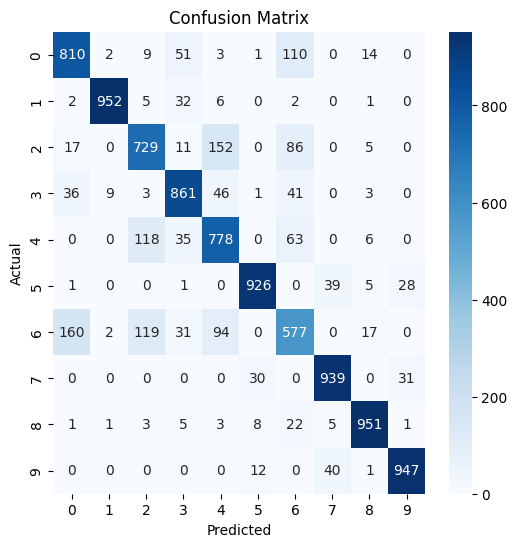

In [65]:
print_metrics(model)